In [7]:
!pip install networkx matplotlib pyvis openai python-dotenv numpy torch transformers tqdm huggingface-hub scipy plotly pandas


[notice] A new release of pip is available: 25.0 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [8]:
from typing import List, Optional
import json
from openai import OpenAI
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os

load_dotenv()

# Define your API key securely
# @ANISHA - Enter your OpenAI API key here
# - If you don't have an API key, you can get one by signing up at https://platform.openai.com/signup
API_KEY = os.getenv("OPENAI_API_KEY")

# Initialize the OpenAI client
client = OpenAI(api_key=API_KEY)



def extract_information(text: str):

    client = OpenAI()

    completion = client.chat.completions.create(
        model="gpt-4o",  # Use an appropriate model
        messages=[
            {"role": "system", "content": """You are an expert at extracting information in structured formats to build a knowledge graph.

    Step 1 - Entity detection: Identify all entities in the raw text. Make sure not to miss any out. Entities should be basic and simple, they are akin to Wikipedia nodes.

    Step 2 - Coreference resolution: Find all expressions in the text that refer to the same entity. Make sure entities are not duplicated. In particular do not include entities that are more specific versions themselves, e.g. "a detailed view of jupiter's atmosphere" and "jupiter's atmosphere", only include the most specific version of the entity.

    Step 3 - Relation extraction: Identify semantic relationships between the entities you have identified.

    Format your response as a JSON array of objects, where each object must have exactly these three fields:
    - "subject": The first entity
    - "verb": The relationship between entities
    - "object": The second entity

    Important Tips:
    1. Make sure all information is included in the knowledge graph.
    2. Each triple must have exactly three non-empty strings.
    3. Do not split up related information into separate triples because this could change the meaning.
    4. Before adding a triple to the knowledge graph, check if concatenating subject+verb+object makes sense as a sentence. If not, discard it.
    5. Keep entities and relationships concise but meaningful.
    6. Convert pronouns to their proper noun references when possible.
    7. Keep everything lowercase and in present tense when appropriate.
    8. The output should be a JSON array of objects, each object containing the fields "subject", "verb", and "object", with the starting and ending tags ```json and ``` respectively.
    """},
            {"role": "user", "content": f"Use the given format to extract information from the following input: <input>{text}</input>. Skip the preamble and output the result as a JSON array within <json></json> tags."}
        ]
    )


    if completion.choices:
        response_message = str(completion.choices[0].message.content)
        # process response_message from string to JSON
        print("DEBUG: response_message = ", response_message)
        # if it contains leading and trailing ``` characters, remove them
        if response_message.startswith("```") and response_message.endswith("```"):
            response_message = response_message[3:-3]
        # if it contains leading "json" characters, remove them
        if response_message.startswith("json"):
            response_message = response_message[4:]
        response_message = json.loads(response_message)
        print(response_message)
        # if the response message is a single JSON object, convert it to a list of JSON objects
        if type(response_message) == dict:
            response_message = [response_message]
        return response_message
    else:
        print("No response received.")
        return []




In [9]:
# RAG prompt question-answering examples



def ask_question(question: str, context: str, model="gpt-4-turbo"):
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are an assistant specialized in answering questions based on a given context. Your task is to provide accurate and concise answers to the questions asked. If the answer is not present in the context, you should respond with 'The answer is not present in the given context.'"},
            {"role": "system", "content": "Context: " + context},
            {"role": "user", "content": f"Question: {question}"}
        ]
    )

    if completion.choices:
        response_message = str(completion.choices[0].message.content)
        return response_message
    else:
        print("No response received.")
        return None
    
# Example context and questions
context = """

In the town of Quillhaven—a community renowned for its historic libraries and scholarly traditions—a rare astronomical event was predicted to occur for the first time in over a century. The event, a total solar eclipse, was shrouded in both scientific intrigue and centuries-old folklore. Local legends, drawing on influences from ancient Greek philosophy to indigenous spiritual practices, suggested that eclipses held the power to influence human thought and communal harmony.

At the heart of the community’s preparations was Dr. Lila Montrose, a respected astrophysicist whose career had been dedicated to unraveling the mysteries of cosmic events. Dr. Montrose saw the eclipse as an opportunity to blend modern scientific inquiry with the town’s rich cultural heritage. She proposed a series of public lectures and interactive exhibitions designed to educate residents on the mechanics of the eclipse, while also acknowledging its historical and psychological significance. Her balanced approach aimed to respect both empirical evidence and the symbolic narratives that had long captivated the community.

Meanwhile, Mr. Edmund Blackwell, the town’s dedicated historian, uncovered an ancient manuscript in the dusty archives of Quillhaven’s old library. The manuscript, penned in a mix of archaic English and Latin, detailed elaborate rituals and communal activities that had been performed during similar eclipses in bygone eras. Blackwell argued that these practices were more than mere superstition—they were intrinsic to the town’s identity and had once fostered unity and prosperity. His findings ignited a fervent debate about whether these ancient rituals should be revived as a way to reconnect with Quillhaven’s storied past.

This emerging debate quickly divided the community into two factions. The progressive wing, led by Dr. Montrose, advocated for a balanced, modern approach that combined scientific exploration with cultural respect. In contrast, the conservative faction, inspired by Mr. Blackwell’s manuscript, pushed for a return to the traditional rituals that they believed had been the cornerstone of the town’s former unity and success. As the day of the eclipse drew near, these conflicting views not only highlighted an ideological rift but also symbolized a broader struggle between embracing modernity and preserving historical identity.

In a final effort to bridge these divergent perspectives, town leaders organized a public forum. The forum featured spirited debates and passionate speeches, ultimately concluding with a proposal for collaboration. Both factions agreed that the eclipse could serve as a catalyst for dialogue, urging the community to forge a common path that honored both its scientific curiosity and its deep-rooted traditions.

"""



question = "Explain how the contrasting views of Dr. Lila Montrose and Mr. Edmund Blackwell regarding the upcoming eclipse illustrate the broader tension between modern scientific inquiry and traditional cultural practices. What solution did the town of Quillhaven ultimately propose to address this conflict?"

# Get the answer to the question
answer = ask_question(question, context)
print("Answer:", answer)

source_json = extract_information(context)
output_json = extract_information(answer)

print("Source JSON:", source_json)
print("Output JSON:", output_json)

client_embed = OpenAI(api_key=os.getenv("EMBEDDING_API_KEY"), base_url=os.getenv("EMBEDDING_BASE_URL"))
# Find semantically similar claims out of source and output JSON: "convert these back to text by s-v-o format and compare them", for each claim in output_json, find the two most similar claims in source_json
def find_similar_claims(source_json, output_json):
    source_graphs = []
    output_graphs = []
    for entry in source_json:
        source_graphs.append(f"{entry['subject']} {entry['verb']} {entry['object']}")
    for entry in output_json:
        output_graphs.append(f"{entry['subject']} {entry['verb']} {entry['object']}")

    # create embeddings for source and output graphs
    source_embeddings = client_embed.embeddings.create(input=source_graphs, model="text-embedding-3-small")
    output_embeddings = client_embed.embeddings.create(input=output_graphs, model="text-embedding-3-small")
    # print("Source embeddings:", source_embeddings)
    similar_claims = {}

    for i, output_entry in enumerate(output_json):
        output_embedding = output_embeddings.data[i].embedding  
        similarities = []
        for j, source_entry in enumerate(source_json):
            source_embedding = source_embeddings.data[j].embedding
            # Calculate cosine similarity between embeddings
            similarity = np.dot(output_embedding, source_embedding) / (np.linalg.norm(output_embedding) * np.linalg.norm(source_embedding))
            similarities.append((source_entry, similarity))
        similarities.sort(key=lambda x: x[1], reverse=True)
        # print(similarities)
        output_entry_string = f"{output_entry['subject']} {output_entry['verb']} {output_entry['object']}"
        similar_claims[output_entry_string] = similarities[:3]

    return similar_claims

similar_claims = find_similar_claims(source_json, output_json)



print("Similar Claims:")
for output_entry, source_entries in similar_claims.items():
    print(f"Output Claim: {output_entry}")
    for source_entry, similarity in source_entries:
        print(f"Similar Source Claim: {source_entry} (Similarity: {similarity})")
    print()


Answer: Dr. Lila Montrose and Mr. Edmund Blackwell represent opposing viewpoints regarding the approach to the upcoming total solar eclipse in Quillhaven. Dr. Montrose, an astrophysicist, advocates for a modern approach that combines an educational perspective on the scientific principles governing eclipses with a respect for the town's cultural narratives. Her stance exemplifies a contemporary perspective that seeks to enlighten the community through science while acknowledging the psychological and historical significance of the eclipse. 

Mr. Blackwell, on the other hand, is focused on the town’s historical practices as detailed in an ancient manuscript he discovered. He views these traditional rituals as integral to Quillhaven’s identity and essential for its communal unity and prosperity. His perspective champions preserving and reviving historical cultural practices, seeing them as more than superstitions but as vital links to the past.

The contrast between Blackwell's emphasis 

In [10]:
from huggingface_hub import login  
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

login(token=os.getenv("HUGGINGFACE_TOKEN"))
# Generate pairs from similar claims
claim_pairs = []
for output_entry, source_entries in similar_claims.items():
    source_claims = [f"{source_entry['subject']} {source_entry['verb']} {source_entry['object']}" for source_entry, _ in source_entries]
    source_claims = ";".join(source_claims)
    claim_pairs.append((source_claims, output_entry))

for pair in claim_pairs:
    # Print the pairs in a beautiful format
    print("Input:", pair[0])
    print("Output:", pair[1])
    print()

# Step 1: Load the model
model = AutoModelForSequenceClassification.from_pretrained('vectara/hallucination_evaluation_model', trust_remote_code=True)

# Step 2: Evaluate the hallucination model
# Prompt the pairs
prompt = "<pad> Determine if the hypothesis is true given the premise?\n\nPremise: {text1}\n\nHypothesis: {text2}"
input_pairs = [prompt.format(text1=pair[0], text2=pair[1]) for pair in claim_pairs]
print(input_pairs[0])

# Use text-classification pipeline to predict
classifier = pipeline(
            "text-classification",
            model='vectara/hallucination_evaluation_model',
            tokenizer=AutoTokenizer.from_pretrained('google/flan-t5-base'),
            trust_remote_code=True
        )
full_scores = classifier(input_pairs, top_k=None) # List[List[Dict[str, float]]]

# Optional: Extract the scores for the 'consistent' label
simple_scores = [score_dict['score'] for score_for_both_labels in full_scores for score_dict in score_for_both_labels if score_dict['label'] == 'consistent']

print(simple_scores)

Input: dr. lila montrose aim blend modern scientific inquiry with cultural heritage;dr. lila montrose lead progressive wing;dr. lila montrose propose public lectures and interactive exhibitions
Output: dr. lila montrose represent modern approach

Input: mr. edmund blackwell argue practices are intrinsic to quillhaven's identity;mr. edmund blackwell inspire conservative faction;mr. edmund blackwell uncover ancient manuscript
Output: mr. edmund blackwell represent traditional rituals

Input: dr. lila montrose aim blend modern scientific inquiry with cultural heritage;dr. lila montrose propose public lectures and interactive exhibitions;dr. lila montrose lead progressive wing
Output: dr. lila montrose advocate for educational perspective and cultural narratives

Input: mr. edmund blackwell argue practices are intrinsic to quillhaven's identity;mr. edmund blackwell uncover ancient manuscript;mr. edmund blackwell inspire conservative faction
Output: mr. edmund blackwell focus on historical 

You are using a model of type HHEMv2Config to instantiate a model of type HHEMv2. This is not supported for all configurations of models and can yield errors.


<pad> Determine if the hypothesis is true given the premise?

Premise: dr. lila montrose aim blend modern scientific inquiry with cultural heritage;dr. lila montrose lead progressive wing;dr. lila montrose propose public lectures and interactive exhibitions

Hypothesis: dr. lila montrose represent modern approach


You are using a model of type HHEMv2Config to instantiate a model of type HHEMv2. This is not supported for all configurations of models and can yield errors.
You are using a model of type HHEMv2Config to instantiate a model of type HHEMv2. This is not supported for all configurations of models and can yield errors.
Device set to use mps:0


[0.7156745195388794, 0.1950521618127823, 0.2514227032661438, 0.7451251149177551, 0.8389407396316528, 0.4659237563610077, 0.8978865146636963, 0.9517018795013428, 0.7427177429199219, 0.49105459451675415]


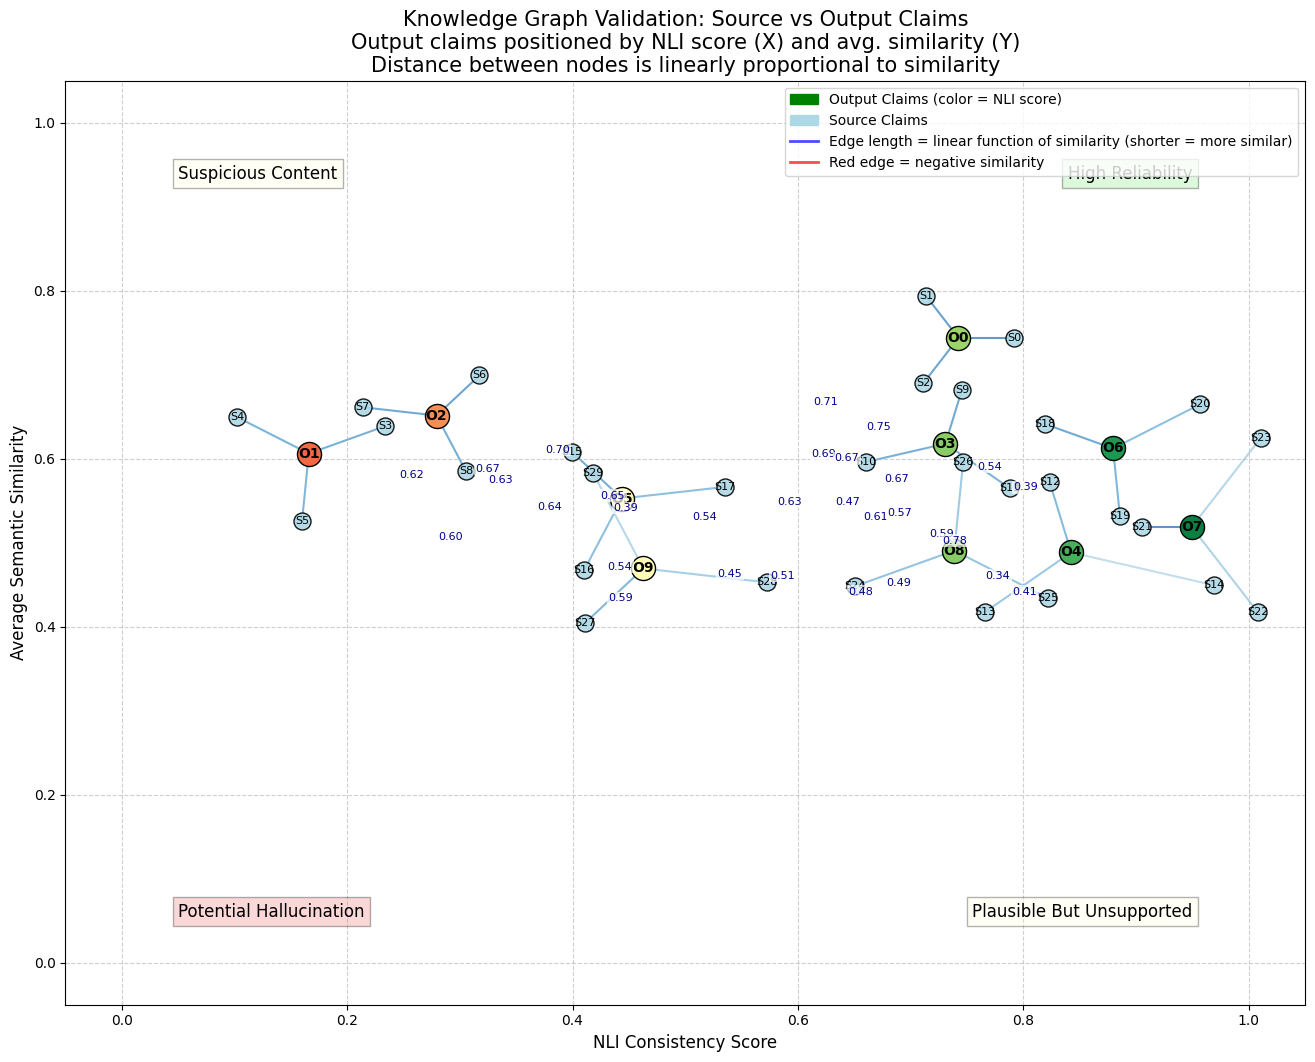

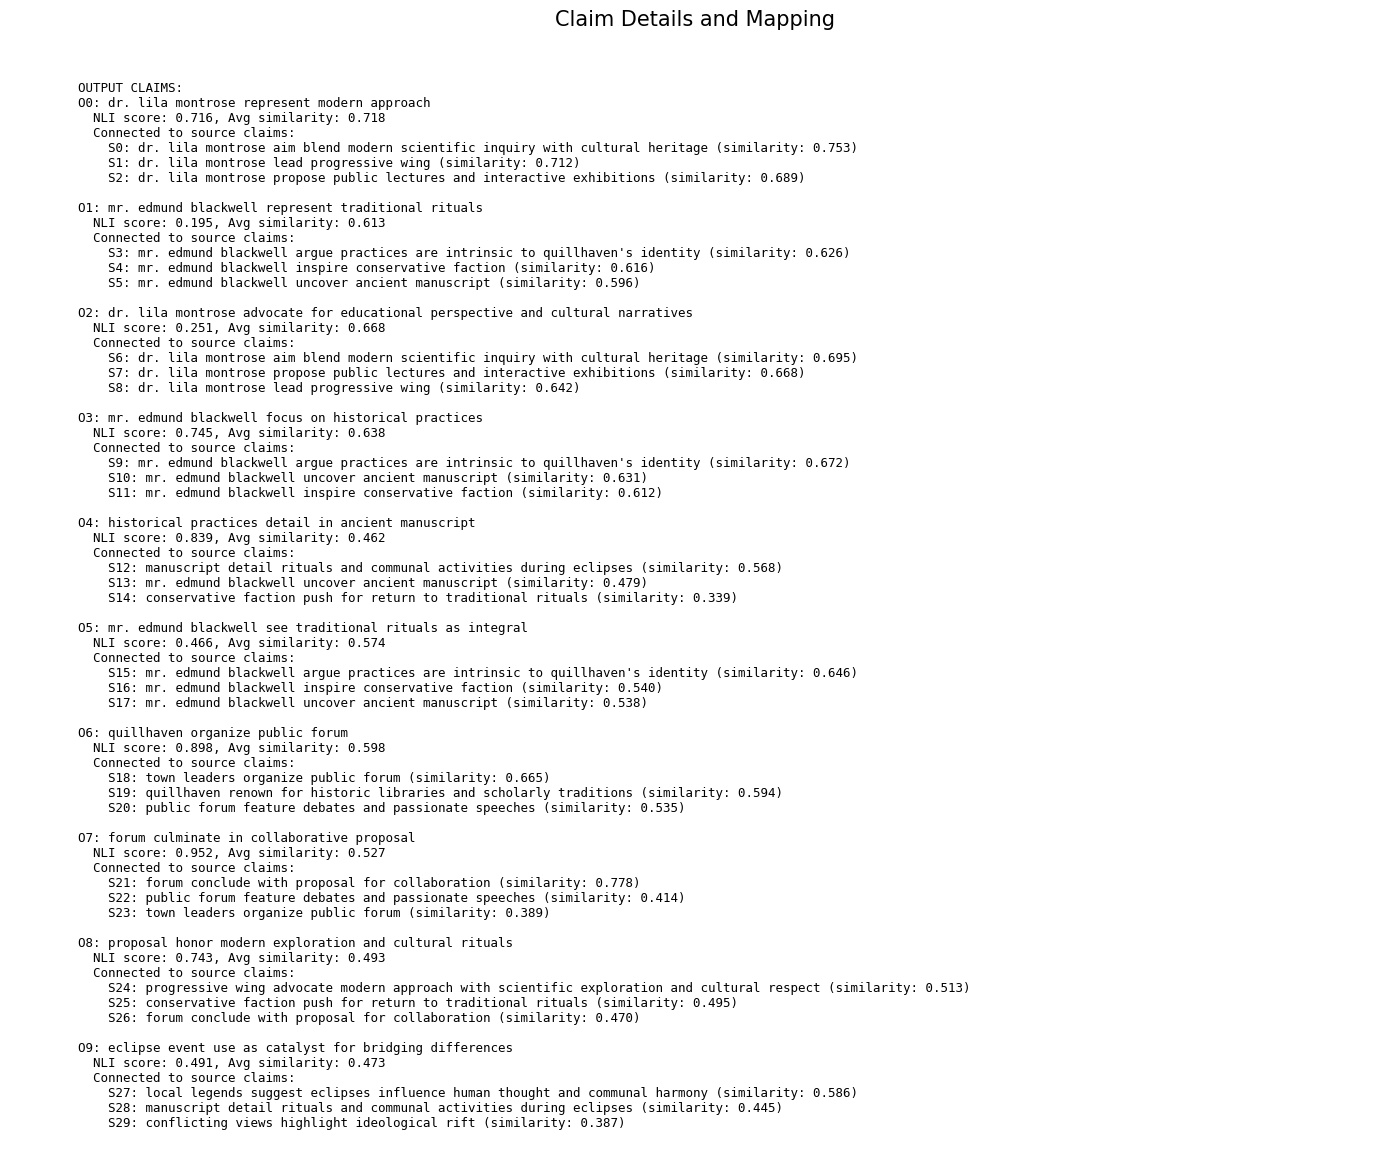

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import math
import random

# Create a figure
plt.figure(figsize=(16, 12))

# Dictionary to store output claim nodes
output_nodes = {}
# Counter for source nodes
source_counter = 0

# Loop through all output claims to create nodes and connections
for i, (output_entry, source_entries) in enumerate(similar_claims.items()):
    # Calculate average similarity for this output claim
    avg_similarity = sum(similarity for _, similarity in source_entries) / len(source_entries)
    
    # Get NLI score for this output claim
    nli_score = simple_scores[i]
    
    # Create output node ID and add to dictionary
    output_node_id = f"O{i}"
    output_nodes[output_entry] = {
        'id': output_node_id,
        'nli_score': nli_score,
        'avg_similarity': avg_similarity,
        'pos': (nli_score, avg_similarity),  # Position based on NLI score (x) and avg similarity (y)
        'connected_sources': []
    }

# Add a small jitter to output positions to reduce overlap
for output_entry, output_data in output_nodes.items():
    # Add a small random offset to each position
    jitter_x = random.uniform(-0.03, 0.03)
    jitter_y = random.uniform(-0.03, 0.03)
    output_data['pos'] = (
        max(0, min(1, output_data['pos'][0] + jitter_x)),  # Keep within [0,1] bounds
        max(0, min(1, output_data['pos'][1] + jitter_y))
    )

# Now add source nodes with appropriate positioning
for i, (output_entry, source_entries) in enumerate(similar_claims.items()):
    output_data = output_nodes[output_entry]
    output_pos = output_data['pos']
    
    # Create a unique source node for each connection, even if the source claim is repeated
    for idx, (source_entry, similarity) in enumerate(source_entries):
        source_text = f"{source_entry['subject']} {source_entry['verb']} {source_entry['object']}"
        source_node_id = f"S{source_counter}"
        source_counter += 1
        
        # Calculate position for source node based on output node position and similarity
        # Use the original linear distance calculation
        similarity_value = max(-1, min(1, similarity))  # Clamp similarity to [-1, 1]
        
        if similarity_value >= 0:
            # For positive similarity, linear relationship
            distance = 0.2 * (1 - similarity_value)
        else:
            # For negative similarity, set a larger distance
            distance = 0.4 * (1 - similarity_value)
        
        # Position nodes in a radial pattern with more distinct angles
        angle = (idx * 2 * math.pi / 3) + (i * math.pi / 7)  # Offset angle based on output index
        x_offset = distance * math.cos(angle)
        y_offset = distance * math.sin(angle)
        
        source_pos = (output_pos[0] + x_offset, output_pos[1] + y_offset)
        
        # Store information about this source node
        output_nodes[output_entry]['connected_sources'].append({
            'id': source_node_id,
            'text': source_text,
            'similarity': similarity,
            'pos': source_pos,
            'source_entry': source_entry
        })

# Draw the graph
# First draw all edges
for output_entry, output_data in output_nodes.items():
    output_pos = output_data['pos']
    
    for source_data in output_data['connected_sources']:
        source_pos = source_data['pos']
        similarity = source_data['similarity']
        
        # Choose edge color based on similarity
        if similarity < 0:
            edge_color = 'red'
            alpha = 0.7
        else:
            edge_color = plt.cm.Blues(similarity)
            alpha = 0.7
        
        # Draw the edge
        plt.plot([output_pos[0], source_pos[0]], [output_pos[1], source_pos[1]], 
                 color=edge_color, alpha=alpha, zorder=1)

# Then draw all nodes
# Output nodes
for output_entry, output_data in output_nodes.items():
    pos = output_data['pos']
    nli_score = output_data['nli_score']
    
    # Color based on NLI score
    node_color = plt.cm.RdYlGn(nli_score)
    
    # Draw the node
    plt.scatter(pos[0], pos[1], color=node_color, s=300, edgecolor='black', zorder=3)
    
    # Add the label
    plt.text(pos[0], pos[1], output_data['id'], 
             horizontalalignment='center', verticalalignment='center',
             fontweight='bold', fontsize=10, color='black', zorder=4)
    
    # Draw source nodes for this output node
    for source_data in output_data['connected_sources']:
        source_pos = source_data['pos']
        source_id = source_data['id']
        similarity = source_data['similarity']
        
        # Draw the node
        plt.scatter(source_pos[0], source_pos[1], color='lightblue', s=150, 
                   edgecolor='black', alpha=0.9, zorder=2)
        
        # Add the label with similarity value
        plt.text(source_pos[0], source_pos[1], source_id, 
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=8, color='black', zorder=4)
        
        # Show similarity value near the edge
        mid_x = (output_pos[0] + source_pos[0]) / 2
        mid_y = (output_pos[1] + source_pos[1]) / 2
        # Add a small offset to the text to avoid overlapping the edge
        offset_x = (source_pos[0] - output_pos[0]) * 0.1
        offset_y = (source_pos[1] - output_pos[1]) * 0.1
        plt.text(mid_x + offset_x, mid_y + offset_y, f"{similarity:.2f}", 
                 fontsize=8, color='darkblue' if similarity >= 0 else 'darkred', zorder=5,
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Set axis limits with padding
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

# Add axis labels
plt.xlabel('NLI Consistency Score', fontsize=12)
plt.ylabel('Average Semantic Similarity', fontsize=12)

# Create legend
output_patch = mpatches.Patch(color='green', label='Output Claims (color = NLI score)')
source_patch = mpatches.Patch(color='lightblue', label='Source Claims')
pos_edge = Line2D([0], [0], color='blue', lw=2, alpha=0.7, 
                 label='Edge length = linear function of similarity (shorter = more similar)')
neg_edge = Line2D([0], [0], color='red', lw=2, alpha=0.7, 
                 label='Red edge = negative similarity')

plt.legend(handles=[output_patch, source_patch, pos_edge, neg_edge], 
          loc='upper right', fontsize=10)

# Add a title
plt.title('Knowledge Graph Validation: Source vs Output Claims\n' + 
         'Output claims positioned by NLI score (X) and avg. similarity (Y)\n' +
         'Distance between nodes is linearly proportional to similarity', 
         fontsize=15)

# Add quadrant labels to help with interpretation
plt.text(0.95, 0.95, "High Reliability", fontsize=12, ha='right', va='top', 
         bbox=dict(facecolor='lightgreen', alpha=0.3))
plt.text(0.05, 0.95, "Suspicious Content", fontsize=12, ha='left', va='top',
         bbox=dict(facecolor='lightyellow', alpha=0.3))
plt.text(0.95, 0.05, "Plausible But Unsupported", fontsize=12, ha='right', va='bottom',
         bbox=dict(facecolor='lightyellow', alpha=0.3))
plt.text(0.05, 0.05, "Potential Hallucination", fontsize=12, ha='left', va='bottom',
         bbox=dict(facecolor='lightcoral', alpha=0.3))

# Create a separate figure for the claim details
plt.figure(figsize=(14, 12))
plt.axis('off')
plt.title('Claim Details and Mapping', fontsize=15)

# Create text for the table
table_text = []
table_text.append("OUTPUT CLAIMS:")
for i, (output_entry, output_data) in enumerate(output_nodes.items()):
    # Add output claim information
    table_text.append(f"{output_data['id']}: {output_entry}")
    table_text.append(f"  NLI score: {output_data['nli_score']:.3f}, Avg similarity: {output_data['avg_similarity']:.3f}")
    
    # Add information about connected source claims
    table_text.append("  Connected to source claims:")
    for source_data in output_data['connected_sources']:
        source_text = source_data['text']
        source_id = source_data['id']
        similarity = source_data['similarity']
        
        # Format similarity with indicator for negative values
        sim_text = f"{similarity:.3f}"
        if similarity < 0:
            sim_text = f"{sim_text} (NEGATIVE)"
        
        table_text.append(f"    {source_id}: {source_text} (similarity: {sim_text})")
    
    # Add a blank line for readability
    table_text.append("")

plt.text(0.05, 0.95, '\n'.join(table_text), transform=plt.gca().transAxes, 
         fontsize=9, va='top', family='monospace')

plt.tight_layout()
plt.show()

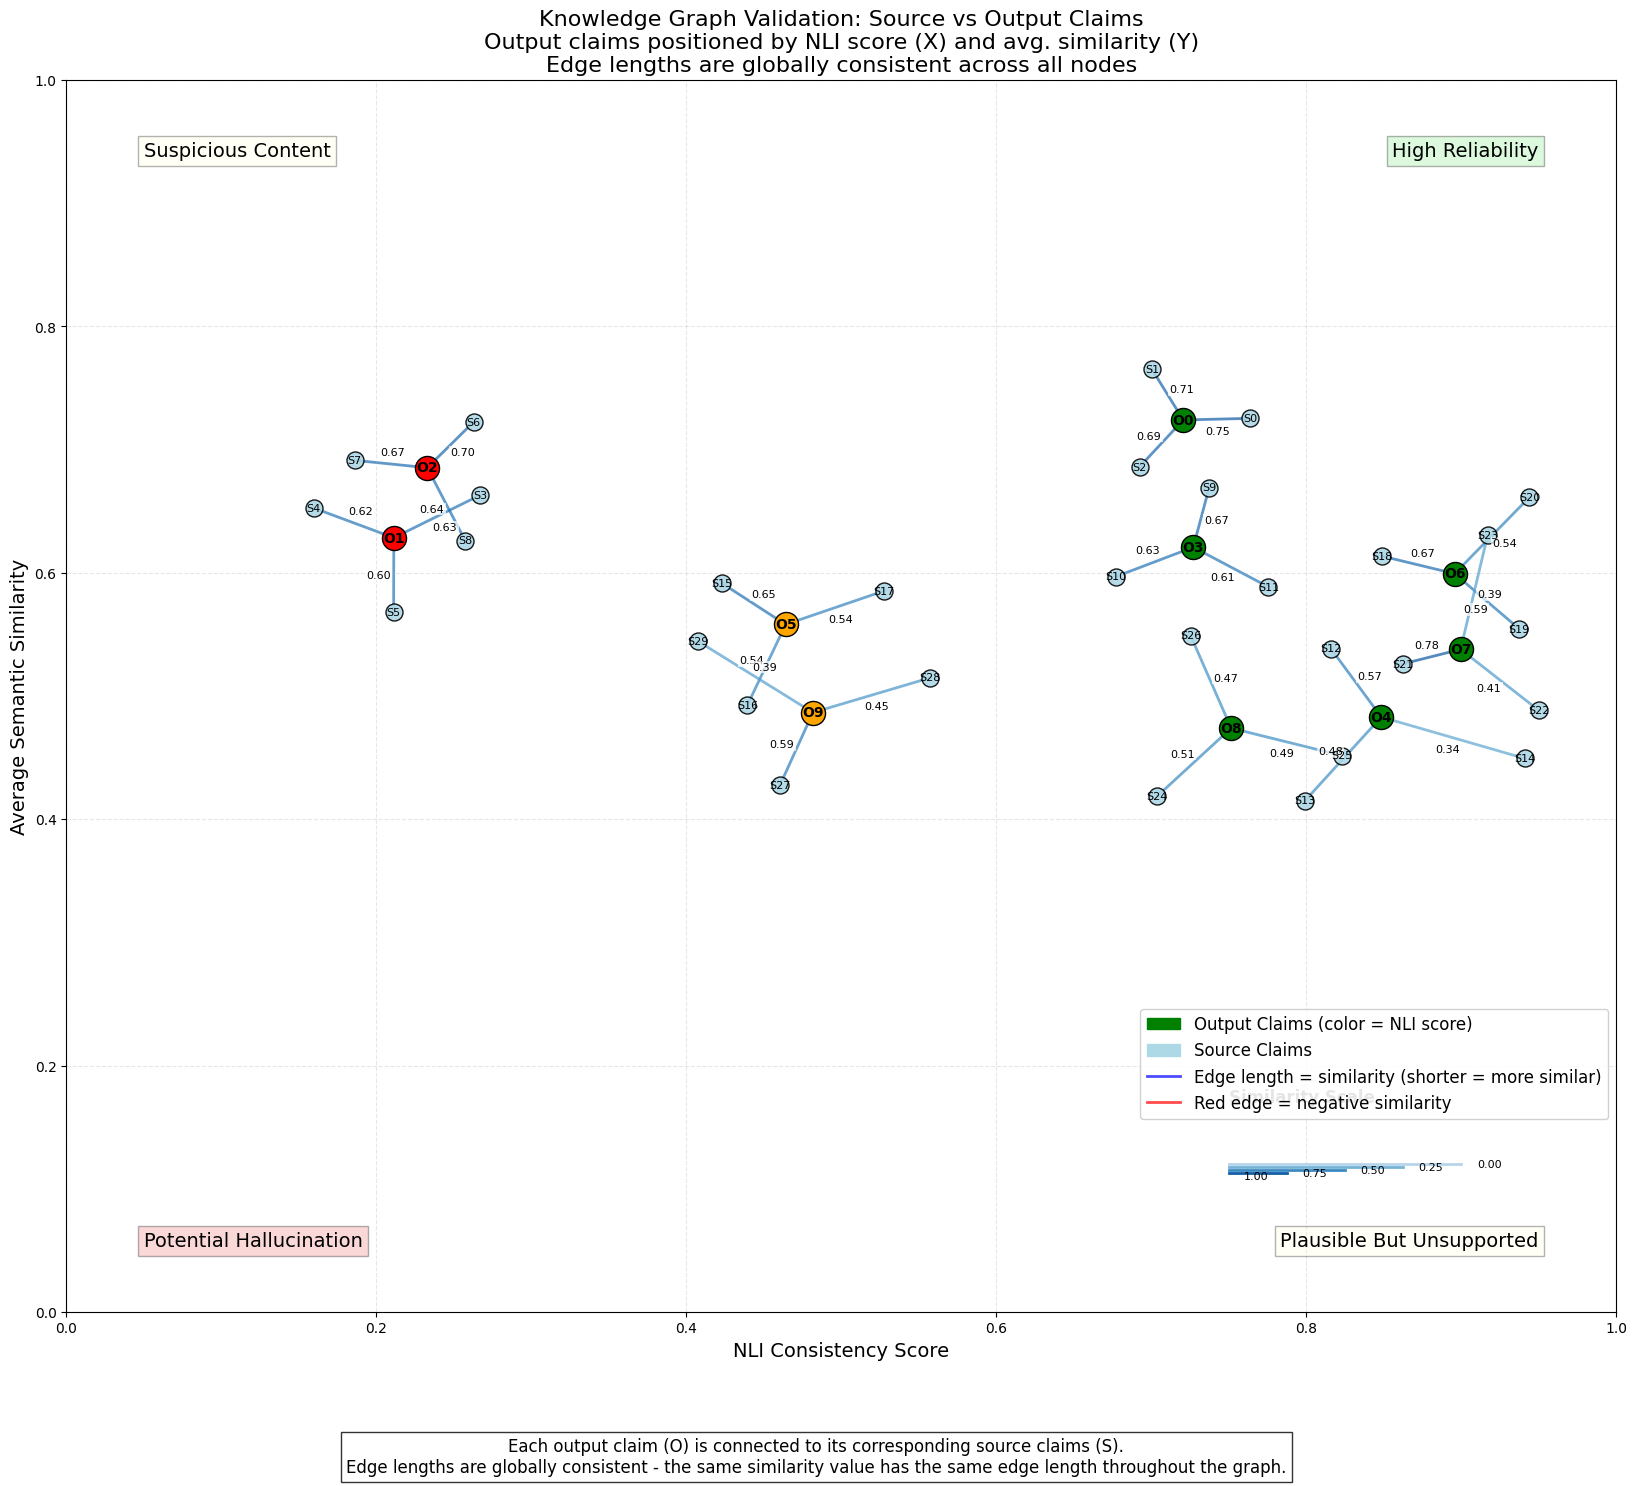

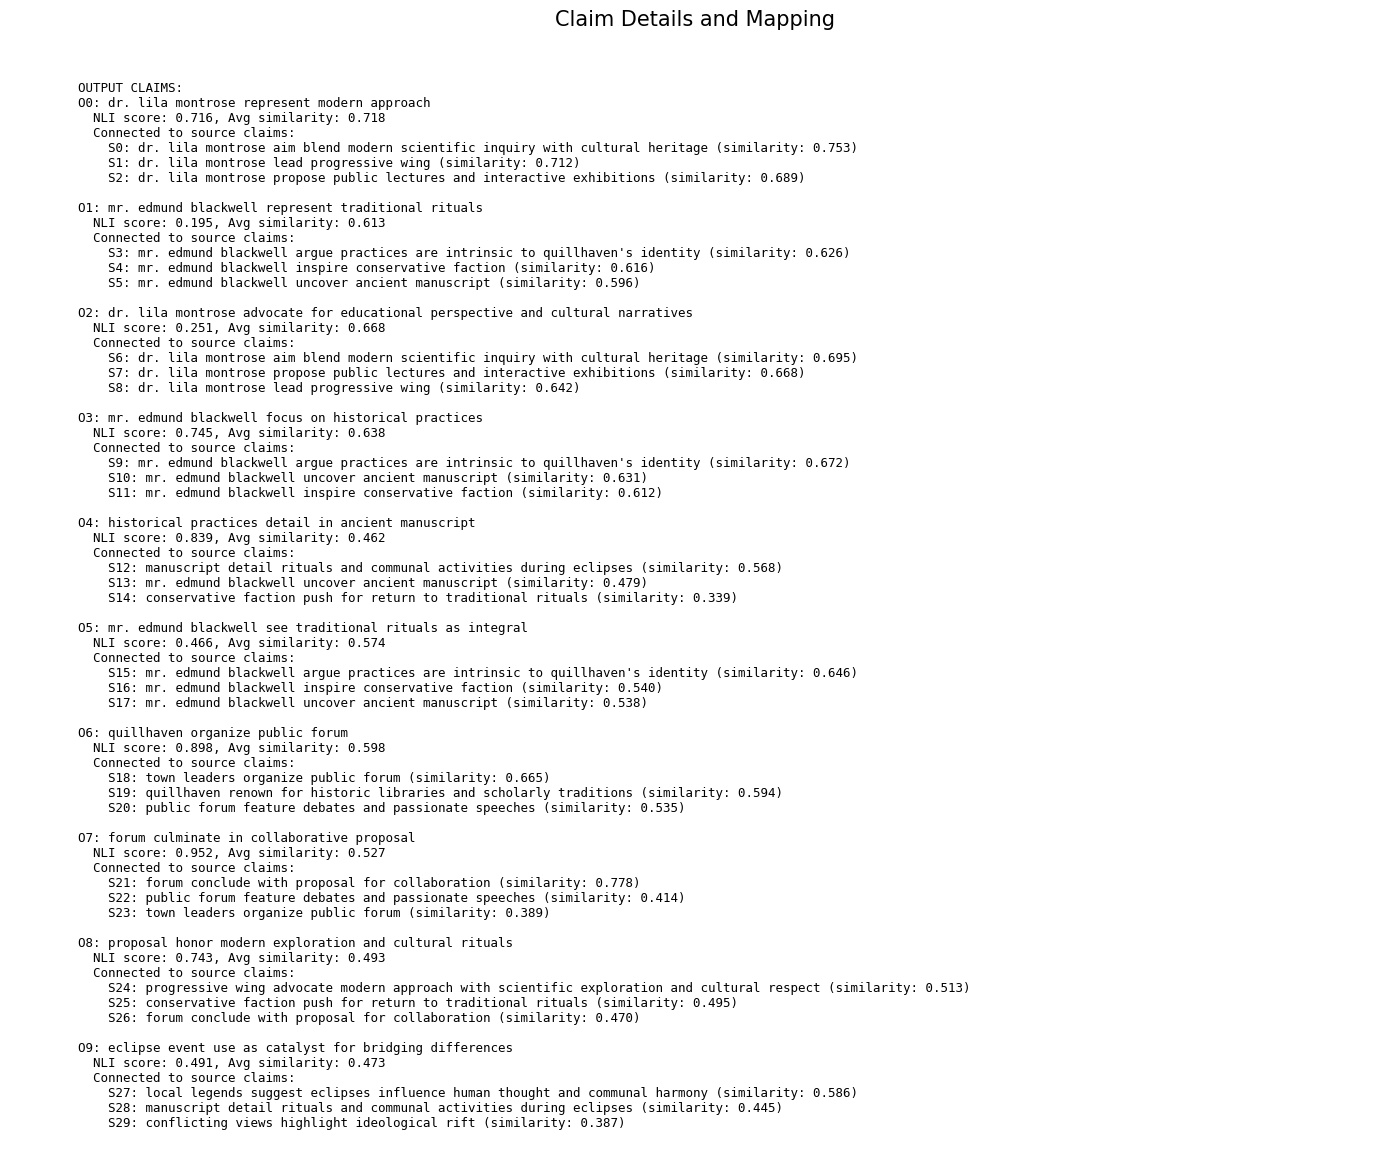

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import math
import random
from scipy.spatial.distance import cdist
from scipy.spatial import distance

# Create a new figure with a larger size
plt.figure(figsize=(20, 16))

# Dictionary to store output claim nodes and positions
output_nodes = {}
output_positions = {}
source_counter = 0

# First, create all the output nodes
for i, (output_entry, source_entries) in enumerate(similar_claims.items()):
    # Calculate average similarity for this output claim
    avg_similarity = sum(similarity for _, similarity in source_entries) / len(source_entries)
    
    # Get NLI score for this output claim
    nli_score = simple_scores[i]
    
    # Add small jitter to prevent direct overlaps
    jitter_x = random.uniform(-0.02, 0.02)
    jitter_y = random.uniform(-0.02, 0.02)
    
    # Position based on NLI score (x) and avg similarity (y) plus jitter
    pos_x = max(0.1, min(0.9, nli_score + jitter_x))
    pos_y = max(0.1, min(0.9, avg_similarity + jitter_y))
    
    # Create node ID and store data
    output_node_id = f"O{i}"
    output_nodes[output_entry] = {
        'id': output_node_id,
        'nli_score': nli_score,
        'avg_similarity': avg_similarity,
        'pos': (pos_x, pos_y),
        'connected_sources': []
    }
    
    # Store position
    output_positions[output_node_id] = (pos_x, pos_y)

# Define a global scale factor for edge lengths
# This will make the relationship between similarity and edge length globally consistent
GLOBAL_SCALE_FACTOR = 0.15  # Adjust as needed

# Function to calculate the source node position based on output node position and similarity
def calculate_source_position(output_pos, similarity, angle):
    """
    Calculate source node position with a globally consistent edge length.
    Shorter edges = higher similarity, globally consistent across all nodes.
    """
    # Ensure similarity is in valid range
    similarity_value = max(-1, min(1, similarity))
    
    # Calculate the distance - globally consistent for the same similarity value
    if similarity_value >= 0:
        distance = GLOBAL_SCALE_FACTOR * (1 - similarity_value)
    else:
        distance = GLOBAL_SCALE_FACTOR * 2 * (1 - similarity_value)
    
    # Calculate position
    x_offset = distance * math.cos(angle)
    y_offset = distance * math.sin(angle)
    
    # Calculate position
    pos_x = output_pos[0] + x_offset
    pos_y = output_pos[1] + y_offset
    
    # Ensure positions stay within bounds
    pos_x = max(0.05, min(0.95, pos_x))
    pos_y = max(0.05, min(0.95, pos_y))
    
    return (pos_x, pos_y)

# Now add source nodes with consistent edge lengths
all_nodes = {}  # Dictionary to hold all nodes and their data
for i, (output_entry, source_entries) in enumerate(similar_claims.items()):
    output_data = output_nodes[output_entry]
    output_pos = output_data['pos']
    output_id = output_data['id']
    
    # Store output node
    all_nodes[output_id] = {
        'id': output_id,
        'type': 'output',
        'pos': output_pos,
        'text': output_entry,
        'nli_score': output_data['nli_score'],
        'avg_similarity': output_data['avg_similarity'],
        'connections': []
    }
    
    # Calculate evenly spaced angles for source nodes
    base_angles = np.linspace(0, 2*np.pi, len(source_entries)+1)[:-1]
    
    # Add offset to angles based on output node index to prevent overlap
    angles = [angle + (i * 0.5) for angle in base_angles]
    
    for idx, (source_entry, similarity) in enumerate(source_entries):
        source_text = f"{source_entry['subject']} {source_entry['verb']} {source_entry['object']}"
        source_node_id = f"S{source_counter}"
        source_counter += 1
        
        # Calculate source position with globally consistent edge length
        source_pos = calculate_source_position(output_pos, similarity, angles[idx])
        
        # Store source node
        all_nodes[source_node_id] = {
            'id': source_node_id,
            'type': 'source',
            'pos': source_pos,
            'text': source_text,
            'similarity': similarity
        }
        
        # Store connection info
        all_nodes[output_id]['connections'].append({
            'source_id': source_node_id,
            'similarity': similarity
        })

# Now check for overlaps and adjust positions if needed
def adjust_positions_to_reduce_overlap(nodes, min_distance=0.05, iterations=50):
    """Apply force-directed algorithm to reduce node overlaps"""
    
    for _ in range(iterations):
        # Make a copy of positions for this iteration
        positions = {node['id']: node['pos'] for node in nodes.values()}
        
        # Check all pairs of nodes
        node_ids = list(positions.keys())
        
        for i, node_id_i in enumerate(node_ids):
            for j, node_id_j in enumerate(node_ids[i+1:], i+1):
                pos_i = positions[node_id_i]
                pos_j = positions[node_id_j]
                
                # Calculate distance between nodes
                dist = distance.euclidean(pos_i, pos_j)
                
                # If nodes are too close, move them apart
                if dist < min_distance:
                    # Calculate direction vector
                    dx = pos_j[0] - pos_i[0]
                    dy = pos_j[1] - pos_i[1]
                    
                    # Normalize if not zero
                    if dist > 0:
                        dx /= dist
                        dy /= dist
                    else:
                        # If nodes are exactly overlapping, move in random direction
                        angle = random.uniform(0, 2*math.pi)
                        dx = math.cos(angle)
                        dy = math.sin(angle)
                    
                    # Calculate repulsion force
                    force = 0.01 * (min_distance - dist)
                    
                    # Apply force to both nodes in opposite directions
                    # For output nodes, apply half the force to maintain their approximate positions
                    if nodes[node_id_i]['type'] == 'output':
                        force_i = force * 0.5
                    else:
                        force_i = force
                        
                    if nodes[node_id_j]['type'] == 'output':
                        force_j = force * 0.5
                    else:
                        force_j = force
                    
                    # Update positions
                    new_pos_i = (
                        max(0.05, min(0.95, nodes[node_id_i]['pos'][0] - dx * force_i)),
                        max(0.05, min(0.95, nodes[node_id_i]['pos'][1] - dy * force_i))
                    )
                    new_pos_j = (
                        max(0.05, min(0.95, nodes[node_id_j]['pos'][0] + dx * force_j)),
                        max(0.05, min(0.95, nodes[node_id_j]['pos'][1] + dy * force_j))
                    )
                    
                    nodes[node_id_i]['pos'] = new_pos_i
                    nodes[node_id_j]['pos'] = new_pos_j
    
    return nodes

# First adjustment to avoid overlaps
all_nodes = adjust_positions_to_reduce_overlap(all_nodes)

# After avoiding overlaps, recalculate source positions to maintain consistent edge lengths
# This ensures that after overlap adjustment, we still maintain our globally consistent edge lengths
for node_id, node_data in all_nodes.items():
    if node_data['type'] == 'output':
        output_pos = node_data['pos']
        
        # For each connection, recalculate source position
        for idx, conn in enumerate(node_data['connections']):
            source_id = conn['source_id']
            similarity = conn['similarity']
            
            # Calculate angle based on current positions
            source_pos = all_nodes[source_id]['pos']
            angle = math.atan2(source_pos[1] - output_pos[1], source_pos[0] - output_pos[0])
            
            # Recalculate position with globally consistent edge length
            new_pos = calculate_source_position(output_pos, similarity, angle)
            
            # Update position
            all_nodes[source_id]['pos'] = new_pos

# Run one more overlap adjustment round
all_nodes = adjust_positions_to_reduce_overlap(all_nodes)

# Add a reference scale for similarity values
def add_similarity_scale(ax, x_pos=0.05, y_pos=0.05, width=0.15):
    """Add a reference scale showing edge lengths for different similarity values"""
    sim_values = [0.0, 0.25, 0.5, 0.75, 1.0]
    
    # Calculate lengths based on the global scale
    lengths = [GLOBAL_SCALE_FACTOR * (1 - sim) for sim in sim_values]
    
    # Add title
    plt.text(x_pos, y_pos + 0.05, "Similarity Scale", 
             fontsize=12, fontweight='bold', horizontalalignment='left')
    
    # Draw reference lines
    for sim, length in zip(sim_values, lengths):
        # Create reference point
        start_x = x_pos
        start_y = y_pos - 0.01*sim  # Small vertical offset for readability
        
        # Draw line
        end_x = start_x + length
        end_y = start_y
        
        plt.plot([start_x, end_x], [start_y, end_y], 
                 color=plt.cm.Blues(0.3 + 0.7 * sim), linewidth=2)
        
        # Add labels
        plt.text(end_x + 0.01, end_y, f"{sim:.2f}", 
                 fontsize=8, verticalalignment='center')

# Create a plot based on the all_nodes data
# First draw edges
for node_id, node_data in all_nodes.items():
    if node_data['type'] == 'output':
        output_pos = node_data['pos']
        
        # Draw edges to connected sources
        for conn in node_data['connections']:
            source_id = conn['source_id']
            similarity = conn['similarity']
            source_pos = all_nodes[source_id]['pos']
            
            # Set edge color based on similarity
            if similarity < 0:
                edge_color = 'red'
                alpha = 0.7
            else:
                edge_color = plt.cm.Blues(0.3 + 0.7 * similarity)
                alpha = 0.7
            
            # Draw the edge
            plt.plot([output_pos[0], source_pos[0]], [output_pos[1], source_pos[1]], 
                     color=edge_color, alpha=alpha, linewidth=2, zorder=1)
            
            # Add similarity label near the edge
            mid_x = (output_pos[0] + source_pos[0]) / 2
            mid_y = (output_pos[1] + source_pos[1]) / 2
            
            # Calculate offset to avoid overlapping the line
            dx = source_pos[0] - output_pos[0]
            dy = source_pos[1] - output_pos[1]
            angle = math.atan2(dy, dx)
            offset = 0.01
            offset_x = offset * math.sin(angle)
            offset_y = -offset * math.cos(angle)
            
            # Add similarity text
            plt.text(mid_x + offset_x, mid_y + offset_y, f"{similarity:.2f}", 
                     fontsize=8, color='black' if similarity >= 0 else 'darkred', 
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1),
                     horizontalalignment='center', verticalalignment='center', zorder=4)

# Now draw nodes
for node_id, node_data in all_nodes.items():
    pos = node_data['pos']
    
    if node_data['type'] == 'output':
        # Color based on NLI score
        nli_score = node_data['nli_score']
        if nli_score < 0.33:
            node_color = 'red'
        elif nli_score < 0.66:
            node_color = 'orange'
        else:
            node_color = 'green'
        
        # Draw output node
        plt.scatter(pos[0], pos[1], color=node_color, s=300, edgecolor='black', zorder=3)
        
        # Add label
        plt.text(pos[0], pos[1], node_id, 
                 horizontalalignment='center', verticalalignment='center',
                 fontweight='bold', fontsize=10, color='black', zorder=4)
    else:
        # Draw source node
        plt.scatter(pos[0], pos[1], color='lightblue', s=150, 
                   edgecolor='black', alpha=0.9, zorder=2)
        
        # Add label
        plt.text(pos[0], pos[1], node_id, 
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=8, color='black', zorder=4)

# Add similarity scale as reference
add_similarity_scale(plt.gca(), x_pos=0.75, y_pos=0.12, width=0.15)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.3)

# Set axis limits with padding
plt.xlim(0, 1)
plt.ylim(0, 1)

# Add axis labels
plt.xlabel('NLI Consistency Score', fontsize=14)
plt.ylabel('Average Semantic Similarity', fontsize=14)

# Create legend
output_patch = mpatches.Patch(color='green', label='Output Claims (color = NLI score)')
source_patch = mpatches.Patch(color='lightblue', label='Source Claims')
pos_edge = Line2D([0], [0], color='blue', lw=2, alpha=0.7, 
                 label='Edge length = similarity (shorter = more similar)')
neg_edge = Line2D([0], [0], color='red', lw=2, alpha=0.7, 
                 label='Red edge = negative similarity')

plt.legend(handles=[output_patch, source_patch, pos_edge, neg_edge], 
          loc='lower right', fontsize=12, bbox_to_anchor=(1.0, 0.15),
          framealpha=0.9)

# Add quadrant labels to help with interpretation
plt.text(0.95, 0.95, "High Reliability", fontsize=14, ha='right', va='top', 
         bbox=dict(facecolor='lightgreen', alpha=0.3))
plt.text(0.05, 0.95, "Suspicious Content", fontsize=14, ha='left', va='top',
         bbox=dict(facecolor='lightyellow', alpha=0.3))
plt.text(0.95, 0.05, "Plausible But Unsupported", fontsize=14, ha='right', va='bottom',
         bbox=dict(facecolor='lightyellow', alpha=0.3))
plt.text(0.05, 0.05, "Potential Hallucination", fontsize=14, ha='left', va='bottom',
         bbox=dict(facecolor='lightcoral', alpha=0.3))

# Add a title
plt.title('Knowledge Graph Validation: Source vs Output Claims\n' + 
         'Output claims positioned by NLI score (X) and avg. similarity (Y)\n' +
         'Edge lengths are globally consistent across all nodes', 
         fontsize=16)

# Add descriptive text
plt.figtext(0.5, 0.01, 
           "Each output claim (O) is connected to its corresponding source claims (S).\n" +
           "Edge lengths are globally consistent - the same similarity value has the same edge length throughout the graph.",
           ha='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Create a separate figure for the claim details
plt.figure(figsize=(14, 12))
plt.axis('off')
plt.title('Claim Details and Mapping', fontsize=15)

# Create text for the table
table_text = []
table_text.append("OUTPUT CLAIMS:")

# Use all_nodes structure for the details table
output_nodes_list = [node for node_id, node in all_nodes.items() if node['type'] == 'output']

for output_node in output_nodes_list:
    # Add output claim information
    output_id = output_node['id']
    output_text = output_node['text']
    table_text.append(f"{output_id}: {output_text}")
    table_text.append(f"  NLI score: {output_node['nli_score']:.3f}, Avg similarity: {output_node['avg_similarity']:.3f}")
    
    # Add information about connected source claims
    table_text.append("  Connected to source claims:")
    
    # Process connections
    for connection in output_node['connections']:
        source_id = connection['source_id']
        similarity = connection['similarity']
        source_text = all_nodes[source_id]['text']
        
        # Format similarity with indicator for negative values
        sim_text = f"{similarity:.3f}"
        if similarity < 0:
            sim_text = f"{sim_text} (NEGATIVE)"
        
        table_text.append(f"    {source_id}: {source_text} (similarity: {sim_text})")
    
    # Add a blank line for readability
    table_text.append("")

plt.text(0.05, 0.95, '\n'.join(table_text), transform=plt.gca().transAxes, 
         fontsize=9, va='top', family='monospace')

plt.tight_layout()
plt.show()